In [1]:
%pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-cpython-310
      creating build/lib.macosx-11.0-arm64-cpython-310/pycocotools
      copying pycocotools/coco.py -> build/lib.macosx-11.0-arm64-cpython-310/pycocotools
      copying pycocotools/mask.py -> build/lib.macosx-11.0-arm64-cpython-310/pycocotools
      copying pycocotools/__init__.py -> build/lib.macosx-11.0-arm64-cpython-310/pycocotools
      copying pycocotools/cocoeval.py -> build/lib.macosx-11.0-arm64-cpython-310/pycocotools
      running build_ext
      building 'pycocotools._mask' extension
      creating build/common
      creating build/temp.macosx-11.0-arm64-cpython-310
      creating build/temp.macosx-11.0-arm64-cpython-310/pycocotools
      clang -Wno-unused-result -Wsign-compare -Wunreachable-

In [1]:
# Libraries
import pandas as pd
import numpy as np
import os
import shutil

import torch
import json
import cv2
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from PIL import Image

In [2]:
# image_info
img_info = pd.read_csv("image_data.csv")#.drop("Unnamed: 0", axis =1)
img_info.shape

(2089, 4)

In [3]:
img_info.head(1)

,id,file_name,width,height
0,232566,000000232566.jpg,300,300


In [4]:
img_list = os.listdir("/Users/ika/Documents/baamtu_files/annotations/TrainImages/images_train")
img_list[:10]

['000000213403.png',
 '000000150596.png',
 '000000211572.png',
 '000000046486.png',
 '000000056871.png',
 '000000090942.png',
 '000000182375.png',
 '000000075931.png',
 '000000151663.png',
 '000000155363.png']

In [5]:
img_root_path = '/Users/ika/Documents/baamtu_files/annotations/TrainImages/images_train'

In [6]:
with open('annotation-small.json', 'r') as f:
    annot_data = json.load(f)

In [8]:
# pd.DataFrame(annot_data['annotations']).shape

In [14]:
coco_anno = COCO('annotation-small.json')
cat_ids = coco_anno.getCatIds()
cats = coco_anno.loadCats(cat_ids)
img_ids = img_info.id.to_list()

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [15]:
len(img_ids)

2089

In [17]:
index = int( len(img_ids) * 0.80)
train_ids = img_ids[:index]
val_ids = img_ids[index:]

In [10]:
def get_mask(coco, img_id, cat_ids):
    img_inf = coco.loadImgs(img_id)[0]
    img_shape = (img_inf['width'], img_inf['height'], len(cat_ids))
    ann_ids = coco_anno.getAnnIds(imgIds=img_id,
                                  catIds=cat_ids,
                                  iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    masks = np.zeros(img_shape)
    for idx, cat_id in enumerate(cat_ids):
        mask = np.zeros(img_shape[:2])
        for ann in anns:
            if cat_id == ann['category_id']:
                annToMask = coco_anno.annToMask(ann)
                mask = np.maximum(mask, annToMask)
        masks[:, :, idx] = mask
    return masks

In [24]:
class createDataset(Dataset):
    def __init__(self, root_dir, img_ids, 
                 cat_ids, coco_api, 
                 save_image_path,
                 save_mask_path, 
                 save = True):
        self.root_dir = root_dir
        self.img_ids = img_ids
        self.cat_ids = cat_ids
        self.coco_api = coco_api
        self.save = save
        self.save_image_path = save_image_path
        self.save_mask_path = save_mask_path
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx] # get image idx
        img_inf = self.coco_api.loadImgs(img_id)[0] # load image info
        file_name = img_inf['file_name'].split(".")[0] + ".png" # get the image file name
        file_path = f'{self.root_dir}/{file_name}'
        img = Image.open(file_path).convert('RGB')
        mask = get_mask(self.coco_api, img_id, self.cat_ids)

        if self.save:
          img.save(self.save_image_path + file_name)
          cv2.imwrite(self.save_mask_path + file_name, mask)

        return img, mask
    
    def __len__(self):
        return len(self.img_ids)

In [27]:
IMAGE_ROOT = 'images_test'

ds = createDataset(root_dir=IMAGE_ROOT, 
                   img_ids = val_ids, 
                   cat_ids=cat_ids, 
                   coco_api=coco_anno,
                   save = True,
                   save_image_path='./save/img/',
                   save_mask_path='./save/mask/')

In [30]:
np.unique(ds[0][1])

array([0., 1.])

In [40]:
np.unique(np.array(Image.open('/Users/ika/Documents/baamtu_files/annotations/TrainImages/train_masks/000000000095.png')))

array([0, 1], dtype=uint8)

In [32]:
index = int( len(img_ids) * 0.80)

train_ids = img_ids[:index]
val_ids = img_ids[index:]

print(f"length of train ids is {len(train_ids)} and validation ids {len(val_ids)}")

length of train ids is 1671 and validation ids 418


In [33]:
train_IMAGE_ROOT = 'images_train'

train_ds = createDataset(root_dir=train_IMAGE_ROOT, 
                   img_ids = train_ids, 
                   cat_ids=cat_ids, 
                   coco_api=coco_anno,
                   save = True,
                   save_image_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/images_train/',
                   save_mask_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/train_masks/')

test_IMAGE_ROOT = 'images_test'
val_ds = createDataset(root_dir=test_IMAGE_ROOT, 
                   img_ids = val_ids, 
                   cat_ids=cat_ids, 
                   coco_api=coco_anno,
                   save = True,
                   save_image_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/images_test/',
                   save_mask_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/test_masks/')

In [34]:
# save images by running loop
for image in range(len(train_ids)):
  train_ds[image]

In [35]:
# save images by running loop
for image in range(len(val_ids)):
  val_ds[image]

In [83]:
print(f"Number of train images: {len(os.listdir('images_train'))} and No. Labels: {len(os.listdir('train_masks'))}")

Number of train images: 1706 and No. Labels: 1706


In [77]:
print(f"Number of test images: {len(os.listdir('images_test'))} and No. Labels: {len(os.listdir('test_masks'))}")

Number of test images: 433 and No. Labels: 433


In [81]:
TRAIN_IMAGES = os.listdir("images_train")
TRAIN_MASKS = os.listdir('train_masks')
TEST_IMAGES = os.listdir("images_test")
TEST_LABELS = os.listdir("test_masks")

TRAIN_IMAGES_WITHOUT_LABELS = [img for img in TRAIN_IMAGES if img not in TRAIN_MASKS]
TEST_IMAGES_WITHOUT_LABELS = [img for img in TEST_IMAGES if img not in TEST_LABELS]

In [45]:
len(TRAIN_IMAGES_WITHOUT_LABELS), len(TEST_IMAGES_WITHOUT_LABELS)

(35, 15)

In [85]:
np.unique(np.array(Image.open('/Users/ika/Documents/baamtu_files/annotations/TrainImages/test_masks/0e4b37eb-0064.png')))

array([0, 1], dtype=uint8)

In [69]:
def transfer_labels(list_, src, des_path):
    for file in list_:
        mask = Image.open(src +  file)
        mask = np.array(mask)/255.0
        cv2.imwrite(des_path + file.split("_")[1], mask)
    print(f"Successfully saved {len(list_)} labels to {des_path}")

In [82]:
TRAIN_IMAGES_WITHOUT_LABELS = [f"mask_{file}" for file in TRAIN_IMAGES_WITHOUT_LABELS]

transfer_labels(list_ = TRAIN_IMAGES_WITHOUT_LABELS, 
                src='/Users/ika/Documents/baamtu_files/annotations/TrainImages/labels/', 
                des_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/train_masks/')

Successfully saved 35 labels to /Users/ika/Documents/baamtu_files/annotations/TrainImages/train_masks/


In [71]:
TEST_IMAGES_WITHOUT_LABELS = [f"mask_{file}" for file in TEST_IMAGES_WITHOUT_LABELS]

transfer_labels(list_ = TEST_IMAGES_WITHOUT_LABELS, 
                src='/Users/ika/Documents/baamtu_files/annotations/TrainImages/labels/', 
                des_path='/Users/ika/Documents/baamtu_files/annotations/TrainImages/test_masks/')

Successfully saved 15 labels to /Users/ika/Documents/baamtu_files/annotations/TrainImages/test_masks/


In [98]:
# Get local images

local_images_path = os.listdir('/content/drive/MyDrive/segmentation_projects/processed/images/')
local_labels_path = os.listdir('/content/drive/MyDrive/segmentation_projects/processed/labels/')

# sample
local_images_15 = local_images_path[35:]
local_labels_15 = local_labels_path[35:]
# divide between train and test
local_images_35 = [img for img in local_images_path if img not in local_images_15]

local_labels_35 = [label for label in local_labels_path if label not in local_labels_15]

In [123]:
TRAIN_IMAGE_DEST_DIR = os.listdir('/content/drive/MyDrive/mixed_dataset/images_train/')
TRAIN_MASK_DES_DIR = os.listdir('/content/drive/MyDrive/mixed_dataset/annotation_train/')

VAL_IMAGE_DEST_DIR = os.listdir('/content/drive/MyDrive/mixed_dataset/images_test/')
VAL_MASK_DES_DIR = os.listdir('/content/drive/MyDrive/mixed_dataset/annotation_test/')

In [118]:
def move_file(allfiles, source, destination, type = None):
  if type == 'labels':
    for file in allfiles:
      shutil.move(source + file, destination + file.split('_')[1])
  else:
    for file in allfiles:
      shutil.move(source + file, destination + file)

In [120]:
move_file(allfiles=local_images_35, 
          source= '/content/drive/MyDrive/segmentation_projects/processed/images/', 
          destination='/content/drive/MyDrive/mixed_dataset/images_train/', 
          type = None)

In [121]:
move_file(allfiles=local_images_15, 
          source= '/content/drive/MyDrive/segmentation_projects/processed/images/', 
          destination='/content/drive/MyDrive/mixed_dataset/images_test/', 
          type = None)

In [149]:
print(f"Train images: {len(TRAIN_IMAGE_DEST_DIR)}")
print(f"Train labels {len(TRAIN_MASK_DES_DIR)}")
print(f"Val images: {len(VAL_IMAGE_DEST_DIR)}")
print(f"Val labels {len(VAL_MASK_DES_DIR)}")

Train images: 1706
Train labels 1706
Val images: 433
Val labels 434


In [150]:
wrongMask = [image for image in VAL_MASK_DES_DIR if image not in VAL_IMAGE_DEST_DIR]
wrongMask

['30d54083-28.png',
 'a23f6076-20.png',
 '67568ce1-03.png',
 'b013a1f5-10.png',
 '9afa81d4-25.png',
 '.ipynb_checkpoints',
 '7a7a899b-08.png',
 'c48c0ac3-31.png',
 '64015c9d-17.png',
 '3a93a9ec-29.png',
 'f51bda75-15.png',
 'c4100fb7-05.png',
 'f870e4be-19.png']

In [148]:
fixTestSrc = [img for img in wrongMask if img in TRAIN_IMAGE_DEST_DIR] 
# from '/content/drive/MyDrive/mixed_dataset/images_train/' to
#, ---> '/content/drive/MyDrive/mixed_dataset/images_test/'
fixTestSrc

['30d54083-28.png',
 'a23f6076-20.png',
 '67568ce1-03.png',
 'b013a1f5-10.png',
 '9afa81d4-25.png',
 '7a7a899b-08.png',
 'c48c0ac3-31.png',
 '64015c9d-17.png',
 '3a93a9ec-29.png',
 'f51bda75-15.png',
 'c4100fb7-05.png',
 'f870e4be-19.png']

In [140]:
# remove
move_file(allfiles=fixTestSrc, 
          source= '/content/drive/MyDrive/mixed_dataset/images_train/', 
          destination='/content/drive/MyDrive/mixed_dataset/images_test/', 
          type = None)

In [141]:
wrongImg = [image for image in TRAIN_MASK_DES_DIR if image not in TRAIN_IMAGE_DEST_DIR]
wrongImg

['9ad9d934-0071.png',
 '49463a0e-0061.png',
 'b65475d9-0083.png',
 '58ef6cb0-0081.png',
 '97626ff6-0080.png',
 'c559b166-0067.png',
 '42dec8b6-0073.png',
 '0f9961ff-0070.png',
 '790f5283-0074.png',
 '3eb40526-0063.png',
 'ea0dc5ba-0060.png',
 '46c3f17b-0065.png']

In [143]:
fixTrainSrc = [img for img in wrongImg if img in VAL_IMAGE_DEST_DIR] 
# from '/content/drive/MyDrive/mixed_dataset/images_test/'
#----> '/content/drive/MyDrive/mixed_dataset/images_train/'
fixTrainSrc

['9ad9d934-0071.png',
 '49463a0e-0061.png',
 'b65475d9-0083.png',
 '58ef6cb0-0081.png',
 '97626ff6-0080.png',
 'c559b166-0067.png',
 '42dec8b6-0073.png',
 '0f9961ff-0070.png',
 '790f5283-0074.png',
 '3eb40526-0063.png',
 'ea0dc5ba-0060.png',
 '46c3f17b-0065.png']

In [144]:
# remove
move_file(allfiles=fixTrainSrc, 
          source= '/content/drive/MyDrive/mixed_dataset/images_test/', 
          destination= '/content/drive/MyDrive/mixed_dataset/images_train/', 
          type = None)

In [10]:
# fix size

def reset_size(msks, des):
  for mask in msks:
    msk = Image.open(des + mask)
    cv2.imwrite(des + mask, np.array(msk)/255.0)

In [9]:
train_masks = os.listdir('/content/drive/MyDrive/mixed_dataset/annotation_train/')
test_masks = os.listdir('/content/drive/MyDrive/mixed_dataset/annotation_test/')
test_masks = [i for i in test_masks if i.endswith(".png")]
print(len(train_masks))
print(len(test_masks))

train_masks_dir = '/content/drive/MyDrive/mixed_dataset/annotation_train/'
test_masks_dir = '/content/drive/MyDrive/mixed_dataset/annotation_test/'

1706
433


In [22]:
reset_size(msks=train_masks, 
           des=train_masks_dir)

In [23]:
reset_size(msks=test_masks, 
           des=test_masks_dir)

In [35]:
train_masks[:5]

['000000279400.png',
 '000000243493.png',
 '000000006777.png',
 '000000089498.png',
 '000000239767.png']

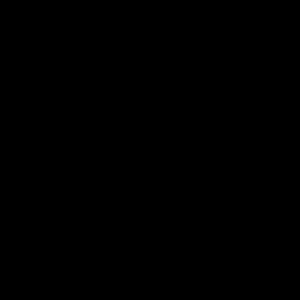

In [36]:
img = Image.open(train_masks_dir + '000000006777.png')
img

In [37]:
np.unique(np.array(img))

array([0], dtype=uint8)

In [30]:
np.array(img).shape

(300, 300)

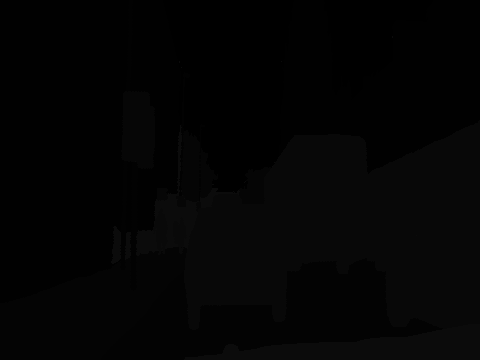

In [31]:
t = Image.open('/content/drive/MyDrive/dataset1.zip (Unzipped Files)/dataset1/annotations_prepped_train/0001TP_006690.png')
t

In [34]:
np.unique(np.array(t))

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11], dtype=uint8)